# Twitter classificator

The aim of this project is to test several Machine Learning classification methods in the context of textual data from Twitter. Being given a tweet, we want to be able to assign it to one of a few pre-defined categories. We will achieve this by using supervised Machine Learning techniques, so we will use a training set of a couple of hundreds of manually labeled tweets. 

## Acquiring data

First step is to acquire labeled tweets for training the model. At first, I tried searching on the Internet (I gathered three sample data sets, 'dataset1', '2' and '3'), but the data sets did not satisfy me, so I decided to gather and manually label Tweets myself.<br>
<br>
I defined six categories for tweets:<br>
Music, Sport, Technology, Weather, Movies, Politics<br>
I also created a seventh, "Other" category for tweets which don't fit in any of the former six.<br>
<br>
I used Twitter streaming API for getting all tweets in English from around the world. Then I filtered them using a set of keywords for each category (I tried to include as many keywords as possible, ~200 per category). In the end, I manually labeled those filtered tweets. This way I gathered dataset with circa 1500 Tweets (~200 per each category and ~300 labeled "Other")<br>
I decided not to put the original script for acquiring data in the repository, as I don't think it is useful after getting the data set. However, there is a script for expanding the training set, of which I will tell more later.
<br>
The acquired data set can be found in data/gathered_dataset/external/training_set.txt file.<br>

## Word Embeddings

Now having a set of labeled sentences (I use the term 'sentence' interchangeably with 'tweet', although it is not strictly correct) we would want to train one of popular classification models, e. g. Neural Network or an SVM classifier. Alas, all these methods require our data to be numerical, not textual. To employ them in our problem we need to firstly get a Word Embedding to represent words from our dataset as vectors of numbers.<br>
<br>
We can find a few pre-trained Word Embeddings on the Internet. I have found a good list in this repository:<br>
https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models<br>
<br>
By default I decided to use two embeddings for comparison:<br>
- Google News embedding (Trained by Google, using word2vec architecture)<br>
- Twitter embedding (Trained by GloVe, using GloVe achitecture)<br>

Google News embedding contains 3 million word vectors of 300 dimensions.<br>
Twitter embedding was trained on actual tweets, so potentially it could be a really good fit. It has several versions in terms of dimensionality, I used the largest one with 200 dimensions. I do not have information about its vocabulary size, however.<br>
<br>
Having at least one word embedding is required for further work. They have sizes of a couple of GB each, so they can take some time to download.<br>
You can also try other embeddings, but it is required that GloVe embeddings are in textual form (.txt) and word2vec in binary form (.bin).<br>
<br>
In code, the default locations for word embeddings are:<br>
'models/word_embeddings/google/GoogleNews-vectors-negative300.bin'<br>
'models/word_embeddings/glove_twitter/glove.twitter.27B.200d.txt'<br>
<br>
You can change them by editing src/common.py file (It contains some constants which are used in scripts for testing model parameters). To do this you need to edit the WORD_EMBEDDINGS list.<br>
<br>
Meaning of each entry in the list is:<br>
(word embedding class (Word2VecEmbedding/GloveEmbedding), ['relative_path_to_file', number of dimensions])<br>
For scripts to work there needs to be at least one item in this list.<br>
<br>
Caution: These embeddings are loaded directly to memory. This means that they can crash on 32-bit version of Python. It is also required to have at least 8 GB RAM.<br>

In [ ]:
# Word2Vec allows us to see the most similar words for a given word
from src.features.word_embeddings.word2vec_embedding import Word2VecEmbedding, run_interactive_word_embedding_test

# change this line for embedding location
model = Word2VecEmbedding('google/GoogleNews-vectors-negative300.bin', 300)

# loading model to memory can take up to a few minutes
model.build()

run_interactive_word_embedding_test(model)

In [ ]:
# Unfortunately, with a library for GloVe model that I used it is not so easy to find the nearest words.
# In this script we can only see raw word vectors
from src.features.word_embeddings.glove_embedding import GloveEmbedding, run_interactive_word_embedding_test

model = GloveEmbedding('glove_twitter/glove.twitter.27B.200d.txt', 200)
model.build()
run_interactive_word_embedding_test(model)

In [ ]:
# This scripts tries to visualize embedded words
# Unfortunately, we see only 3 dimensions, so it uses PCA to reduce dimensionality of word embedding
# PCA is trained on all words which occur in our dataset
# Reducing number of dimensions from 300 to 3 may make our word embedding worthless
# Maybe even in this small dimensionality we can see some patterns
# Color of word point is based on its occurences counts in tweets from each category
# If you run this outside the notebook in standalone python you can click on dots to see words they represent

from src.visualization.visualize_word_embedding import visualize_word_embedding

# You can also use GloVe embedding here
word_emb = Word2VecEmbedding('google/GoogleNews-vectors-negative300.bin', 300)
word_emb.build()

visualize_word_embedding(word_emb)

## Preprocessing tweets

Next step is to look at tweets and see if we can preprocess them so they work better for our model. We want to convert each to tweet a list of words. As an input we have tweets which are unicode strings. I simply convert them to list of words by splitting on whitespaces. Then, I do these conversions:
 - convert all text to lowercase (I assume case does not affect meaning, also SoMe PeOPle WrItE LiKe tHiS)
 - remove hyperlinks
 - remove @UserNames (marks answer to another user's tweet)
 - remove stopwords (words like 'a', 'the' etc) - I use NLTK stopwords corpus
 - convert numbers from 0-20 to textual representation - I use 'inflect' library
 - remove words that contain non-alphanumeric characters

We will also ignore words which don't exist in our Word Embedding. This filtering will be done later, because I wanted the preprocessed dataset to be a single file, fit for all embeddings and models.


In [ ]:
from src.data.dataset import run_interactive_processed_data_generation

# When prompt for folder name, insert 'gathered_dataset'
run_interactive_processed_data_generation()

# data will be saved in data/gathered_dataset/processed/training_set.txt (script shows a relative path)

## Embedding tweets

We have aquired a Word Embedding which allows us to get a vector of numbers for each word. However, our training set consists of lists of words, so we need to specify how to represent a sentence (tweet) based on representations of its words. I test two different approaches:<br>
<br>
First is to simply concatanate word vectors, so for each sentence we get vector of size (number of words in sentence) * (size of a single word vector). To use machine learning algorithms each tweet vector must have the same size, so we need to specify a constant length of a sentence. For instance, we can decide that sentences longer than 30 words will be cut at the end and sentences shorter than 30 words will be filled with zeros.<br>
<br>
Second approach is not to concatanate, but sum word vectors (element-wise). This means that the size of sentence vector will be the same as the size of word vector, so we don't have to artificially cut or lengthen tweets.<br>
<br>
Concatanation yields longer vectors, so models will obviously need more time to compute. On the other hand, we don't lose information about order of words. However, if we look at this example we can see that in training for finding categories order of words may not be so important:<br>
<br>
Tweet 1: "President Obama was great!"<br>
Tweet 2: "What a great president Obama was!"<br>
<br>
Both are obviously about politics and we know this whatever order of words is.<br>
Furthermore, if we have a small training set, we may encounter only one of these tweets. In sum embedding it is not a problem, because both will have very similar representation. In concatanation embedding we may end up with a model which labels correctly only one of them. So it is not obvious which embedding is going to work better.<br>

In [ ]:
# 3D visualization of sentence embeddings, similar to visualization of word embeddings.
# It transforms sentence vectors to 3 dimensions using PCA trained on them.
# Colors of sentences align with their category

from src.visualization.visualize_sentence_embeddings import visualize_sentence_embeddings
from src.features.sentence_embeddings.sentence_embeddings import ConcatenationEmbedding, SumEmbedding
from src.features.word_embeddings.word2vec_embedding import Word2VecEmbedding

# You can also use GloVe embedding here
# To use GloVe embedding: from src.features.word_embeddings.glove_embedding import GloveEmbedding
word_emb = Word2VecEmbedding('google/GoogleNews-vectors-negative300.bin', 300)
word_emb.build()

sentence_embeddings = [
    ConcatenationEmbedding,
    SumEmbedding
]

visualize_sentence_embeddings(word_emb, sentence_embeddings)

## Finding the best model hyperparameters

I chose four standard classifiers from sklearn package to test: 
 
- SVC (SVM Classifier) 
- RandomForestClassifier 
- MLPClassifier (Multi-Layer Perceptron classifier - neural network) 
- KNeighborsClassifier (classification by k-nearest neighbors). 
 
For all these methods, I defined a set of hyperparameters to test: 
 
CLASSIFIERS_PARAMS = [<br>
&nbsp;(SVC,<br>
&nbsp;&nbsp;{"C": list(log_range(-1, 8)),<br>
&nbsp;&nbsp;"gamma": list(log_range(-7, 1))}),<br>
<br>
&nbsp;(RandomForestClassifier,<br>
&nbsp;&nbsp;{"criterion": ["gini", "entropy"],<br>
&nbsp;&nbsp;"min_samples_split": [2, 5, 10, 15],<br>
&nbsp;&nbsp;"min_samples_leaf": [1, 5, 10, 15],<br>
&nbsp;&nbsp;"max_features": [None, "sqrt"]}),<br>
<br>
&nbsp;(MLPClassifier,<br>
&nbsp;&nbsp;{"alpha": list(log_range(-5, -2)),<br>
&nbsp;&nbsp;"learning_rate": ["constant", "adaptive"],<br>
&nbsp;&nbsp;"activation": ["identity", "logistic", "tanh", "relu"],<br>
&nbsp;&nbsp;"hidden_layer_sizes": [(100,), (100, 50)]}),<br>
<br>
&nbsp;(KNeighborsClassifier,<br>
&nbsp;&nbsp;{"n_neighbors": [1, 2, 3, 4, 7, 10, 12, 15, 30, 50, 75, 100, 150],<br>
&nbsp;&nbsp;"weights": ['uniform', 'distance']})<br>
]<br>
 
I test all possible combinations of these parameters, for all word embeddings' and sentence embeddings' combinations. This yields a lot of test cases. Fortunately, classifiers from sklearn package have similar interfaces, so I wrote a generic method for grid-search. This method looks more or less like this: 

for word_embedding in word_embbedings: 
   - build word embedding 
   for sentence_embedding in sentence_embeddings: 
       - build features using sentence embedding and word embedding 
       for classifier_class, tested_parameters in CLASSIFIERS_PARAMS: 
           - run multithreaded GridSearchCV for classifier_class and tested_parameters 
             on traing set labels and built features 
           - safe GridSearchCV results in a summary file in /summaries folder 
 
With models from sklearn we can also use GridSearchCV method from this package, which allows to perform grid search for best parameters in parallel. For each combination of parameters it saves average score in folds. I use folds count equal to 5.<br>
<br>
Testing all models can take up to a couple of hours. Because of this, I save grid search result in summaries folder, which is included in repository. We can use these results to get the best possible model or do some interpretation of the results.<br>
<br>
By viewing grid search results files we can see that the best scores are somewhere around 85%.<br>

In [ ]:
# run grid search on chosen models
# consider doing a backup of text summary files from /summary folder before running this script

from src.common import DATA_FOLDER, FOLDS_COUNT, CLASSIFIERS_PARAMS, \
                       SENTENCE_EMBEDDINGS, CLASSIFIERS_WRAPPERS, WORD_EMBEDDINGS
from src.models.model_testing.grid_search import grid_search

classifiers_to_check = []
for classifier_class, params in CLASSIFIERS_PARAMS:
    to_run = raw_input("Do you wish to test {0} with parameters {1} ? [y/n] "
                       .format(classifier_class.__name__, str(params)))
    if to_run.lower() == 'y' or to_run.lower() == 'yes':
        classifiers_to_check.append((classifier_class, params))

print("*" * 20 + "\n")
grid_search(DATA_FOLDER, FOLDS_COUNT,
            word_embeddings=WORD_EMBEDDINGS,
            sentence_embeddings=SENTENCE_EMBEDDINGS,
            classifiers=classifiers_to_check,
            n_jobs=-1) # uses as many threads as CPU cores

In [ ]:
# now that we have performed grid search, we can train model using the best parameters and test it interactively

from src.common import choose_classifier, LABELS, SENTENCES
from src.models.model_testing.grid_search import get_best_from_grid_search_results
from src.features.build_features import FeatureBuilder
from src.visualization.interactive import interactive_test

classifier = choose_classifier() # choose classifier model
best_parameters = get_best_from_grid_search_results(classifier) # get best parameters

if best_parameters is None: exit(-1) # no grid search summary file for this model

word_emb_class, word_emb_params, sen_emb_class, hyperparams = best_parameters

print ("\nEvaluating model for word embedding: {:s}({:s}), sentence embedding: {:s} \nHyperparameters {:s}\n"
           .format(word_emb_class.__name__, ', '.join(map(str, word_emb_params)), sen_emb_class.__name__, str(hyperparams)))
hyperparams["n_jobs"] = -1 # uses as many threads as CPU cores

print ("Building word embedding...")
word_emb = word_emb_class(*word_emb_params)
word_emb.build()

print ("Building sentence embedding...")
sen_emb = sen_emb_class()
sen_emb.build(word_emb)

print ("Building features...")

# this helper class builds a matrix of features with provided sentence embedding
fb = FeatureBuilder()
fb.build(sen_emb, LABELS, SENTENCES)

print ("Building model...")
clf = classifier(sen_emb, probability=True, **hyperparams)
clf.fit(fb.features, fb.labels)

print ("Model evaluated!...\n")
interactive_test(clf)

In [ ]:
# This scripts visualizes how models work in 2D
# It scatters training samples on a 2D space and colors backgrounds according to model prediction
# It uses best possible parameters from grid search result file
# I use PCA to reduce number of dimension to 2D
# Models perform poorly in 2D, but we can see how boundaries between categories may look for different methods

from src.visualization.visualize_2d import visualize_2d
from src.features.word_embeddings.word2vec_embedding import Word2VecEmbedding
from src.common import choose_multiple_classifiers

classifier_classes = choose_multiple_classifiers()

# use same word embedding for all classifiers - we don't want to load more than one embedding to RAM
word_emb = Word2VecEmbedding('google/GoogleNews-vectors-negative300.bin', 300)
word_emb.build()

visualize_2d(word_emb, classifier_classes)

# Attention: There is probably a bug in matplotlib, which causes the color of the fifth category
# not to be drawn in the background (cyan, 'Movies' category)

## Applying PCA

Until now, I applied PCA several times to make plotting 2D or 3D figures possible. Maybe there is a chance that applying a well fit Principal Component Analysis to our data set will increase model accuracy. The possible option is to fit PCA to our sentece vectors. Then we can train model on sentence vectors transformed with PCA. With reduced number of dimensions, it is also possible that our model could work faster.<br>
<br>
The script below allows user to see how applying PCA to a chosen model works. It cross-validates model built on PCA with dimensions reduced to numbers distributed linearly between 1 and the initial number of dimensions.
There is however a limit - we can't train PCA to number of dimensions which is higher than the number of training samples. So, if we have a dataset of 1500 tweets and we use 5 folds for cross-validation, that means that maximum dimensions after PCA are 1200 (4/5 * 1500). It can be an issue when we use Concatenation Embedding.<br>
<br>
The script measures: cross-validation scores, model training time (including fitting PCA) and average sentence prediction time for a trained model.<br>
<br>
My conclusion after seeing the results is that in our problem applying PCA probably wouldn't be advantegous, as there is a noticable decreasement in training speed and no apparent improvement in accuracy, as compared to model without PCA.

In [ ]:
# training for PCA visualization may take a while, so I also use a summary file for storing the results
from src.visualization.visualize_pca import visualize_pca
from src.common import choose_classifier

classifier_class = choose_classifier()
visualize_pca(classifier_class, n_jobs=-1)

## Expanding training set

After having a way to choose the best parameters for a model I modified the script for mining tweets. In the beginning I used keywords to search for tweets possibly fit for the training set. This gave me quite clear tweets, but may seem my models not general, because they fit mostly to those keywords.<br>
<br>
The approach that I use to expand my current training set is to use a trained classification model to test tweets incoming from Twitter. I declare a threshold, for instance 0.7 and I take into consideration only these tweets, which are assigned to one category with probability more than the threshold.<br>

In [ ]:
from src.data.data_gathering.tweet_miner import mine_tweets

# At first, we train the best possible model we have so far (searching in grid search results files)
# Then, we run as many threads as CPU cores, or two if there is only one core.
# First thread reads stream from Twitter API and puts all tweets in a synchronous queue.
# Other threads read from the queue, test tweets on model
# and if threshold requirement is met, put them in mined_tweets.txt file

# by setting this flag to False we ignore tweets that are classified as "Other"
include_unclassified = False
threshold = 0.7

mine_tweets(threshold, include_unclassified)
# this method can be stopped only by killing the process

In [ ]:
# when we have some tweets in mined_tweets.txt, we must label them manually.
from src.data.data_gathering.tweet_selector import select_tweets

select_tweets()

# Results will be stored in file selected_tweets.txt.
# We can manually merge this file with already existing training set

## Some analysis

Having performed grid search on several models, we can analyse how various hyperparameters perform. Use script below to see some plots showing cross-validation performance for different parameters.

Using TensorFlow backend.


Found Grid Search results in /summaries/gathered_dataset_SvmAlgorithm_grid_search_results.txt
Found Grid Search results in /summaries/gathered_dataset_RandomForestAlgorithm_grid_search_results.txt
Found Grid Search results in /summaries/gathered_dataset_MLPAlgorithm_grid_search_results.txt
Found Grid Search results in /summaries/gathered_dataset_NearestNeighborsAlgorithm_grid_search_results.txt
Found Grid Search results in /summaries/gathered_dataset_KerasNeuralNetworkAlgorithm_grid_search_results.txt
Plot saved in /reports/figures/sentence_embeddings_comparison.svg


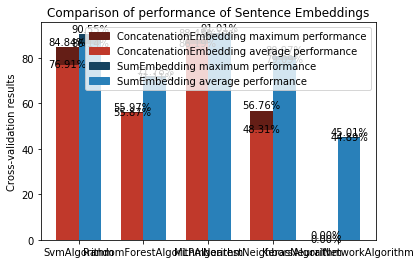

In [1]:
# compare how different sentence embedding perform for all tested models
from src.common import SENTENCE_EMBEDDINGS
from src.visualization.compare_sentence_embeddings import get_grid_search_results_by_sentence_embeddings
from src.visualization.compare_sentence_embeddings import compare_sentence_embeddings_bar_chart

sen_embeddings = [sen_emb.__name__ for sen_emb in SENTENCE_EMBEDDINGS]

grid_search_results = get_grid_search_results_by_sentence_embeddings(sen_embeddings)
compare_sentence_embeddings_bar_chart(grid_search_results)

Found Grid Search results in /summaries/gathered_dataset_SvmAlgorithm_grid_search_results.txt
Found Grid Search results in /summaries/gathered_dataset_RandomForestAlgorithm_grid_search_results.txt
Found Grid Search results in /summaries/gathered_dataset_MLPAlgorithm_grid_search_results.txt
Found Grid Search results in /summaries/gathered_dataset_NearestNeighborsAlgorithm_grid_search_results.txt
Found Grid Search results in /summaries/gathered_dataset_KerasNeuralNetworkAlgorithm_grid_search_results.txt

SvmAlgorithm: Best result: 90.55%, Average result: 53.48%
For embeddings: GloveEmbedding(glove_twitter/glove.twitter.27B.200d.txt, 200), SumEmbedding
And for parameters: {'C': 1000, 'gamma': 1e-05}

RandomForestAlgorithm: Best result: 71.78%, Average result: 59.39%
For embeddings: Word2VecEmbedding(google/GoogleNews-vectors-negative300.bin, 300), SumEmbedding
And for parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 10}

MLPAlgorithm: B

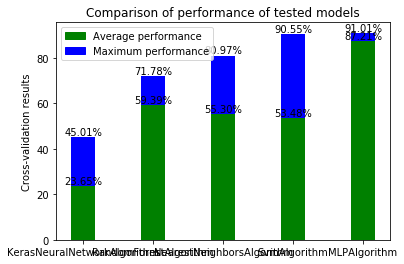

In [2]:
# compare overall performance of all tested models
from src.visualization.compare_models import get_available_grid_search_results
from src.visualization.compare_models import compare_models_bar_chart

best_results_for_models =  get_available_grid_search_results()

for classifier_class, parameters in best_results_for_models:
    word_emb_class, word_emb_params, sen_emb_class, params, best_result, avg_result = parameters

    print ("\n{0}: Best result: {1}%, Average result: {2}%".
           format(classifier_class.__name__, best_result, avg_result))
    print ("For embeddings: {0}({1}), {2}".format(word_emb_class.__name__,
                                                  ', '.join(map(str, word_emb_params)),
                                                  sen_emb_class.__name__))
    print ("And for parameters: {0}".format(str(params)))

compare_models_bar_chart(best_results_for_models)

Choose a classifier by typing a number:
0 - SvmAlgorithm
1 - RandomForestAlgorithm
2 - MLPAlgorithm
3 - NearestNeighborsAlgorithm
4 - KerasNeuralNetworkAlgorithm
0
Found Grid Search results in /summaries/gathered_dataset_SvmAlgorithm_grid_search_results.txt
Choose one or two of the following parameters by typing a number or two numbers, e.g. '1' or '3,4': 
0 - Word Embedding
1 - C
2 - Sentence Embedding
3 - gamma
1,3
Use logarithmic scale for C? [y/n] y
Use logarithmic scale for gamma? [y/n] y
Plot saved in /reports/figures/parameters_SvmAlgorithm_C_and_gamma.svg


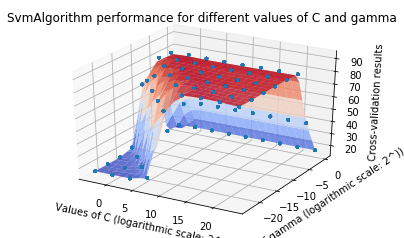

In [5]:
# For a given model, visualize how it performs for a chosen parameter or pair of parameters
from src.common import choose_classifier
from src.visualization.visualize_parameters import get_all_grid_searched_parameters
from src.visualization.visualize_parameters import choose_parameters_to_analyze
from src.visualization.visualize_parameters import analyze_single_parameter
from src.visualization.visualize_parameters import analyze_two_parameters

classifier_class = choose_classifier()
parameters_list = get_all_grid_searched_parameters(classifier_class)
if not parameters_list: # grid search results not found
    exit(-1)
tested_parameters = list(parameters_list[0][0].iterkeys())
parameters_to_analyze = choose_parameters_to_analyze(tested_parameters)

# if we choose a single parameter, draw 1D plot
if len(parameters_to_analyze) == 1:
    analyze_single_parameter(parameters_to_analyze[0], classifier_class, parameters_list)

# if we choose two parameters, draw 2D plot
elif len(parameters_to_analyze) == 2:
    analyze_two_parameters(parameters_to_analyze[0], parameters_to_analyze[1], classifier_class, parameters_list)
